In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, average_precision_score
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit


In [15]:
# Load data
# This assumes data is in a DataFrame called df with 'NDVI', 'NBR' as columns and 'label' as target column

data = pd.read_csv('calculated_data.csv')
data.dropna(subset=['Label'], inplace=True)
data.info()


<class 'pandas.core.frame.DataFrame'>
Index: 627 entries, 0 to 798
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ID          627 non-null    object 
 1   NDVI        627 non-null    object 
 2   NBR         627 non-null    object 
 3   Label       627 non-null    float64
 4   Unnamed: 4  0 non-null      float64
 5   Unnamed: 5  0 non-null      float64
 6   Unnamed: 6  0 non-null      object 
dtypes: float64(3), object(4)
memory usage: 39.2+ KB


In [16]:

data['NBR'] = data['NBR'].apply(lambda x: pd.eval(x, local_dict={'nan': np.nan}))
data['NDVI'] = data['NDVI'].apply(lambda x: pd.eval(x, local_dict={'nan': np.nan}))
data.head()


,ID,NDVI,NBR,Label,Unnamed: 4,Unnamed: 5,Unnamed: 6
0,20230813_100,"[0.7755693773142729, 0.8109320515721594, 0.851...","[0.003078832689977299, 0.049812837737360276, 0...",1.0,NaN,NaN,NaN
1,20230813_101,"[0.34495916148451133, 0.24291931815932866, 0.2...","[0.05116118296949416, -0.026290510714717576, 0...",2.0,NaN,NaN,NaN
2,20230813_102,"[0.8418304439153839, 0.798698150698662, 0.8062...","[0.058663947405941635, 0.04357172884127514, 0....",1.0,NaN,NaN,NaN
3,20230813_103,"[0.5716647915500211, 0.5872206605870187, 0.589...","[0.019482128930850738, 0.009917857640267346, 0...",2.0,NaN,NaN,NaN
4,20230813_104,"[-0.2217794764351386, -0.22595804483580587, -0...","[0.006908720294918405, 0.00880010401111331, -0...",0.0,NaN,NaN,NaN


In [17]:
# Combine NBR and NDVI data into a single feature array
# Flatten each sublist and concatenate NBR and NDVI for each row
X = np.array([np.ravel(nbr + ndvi) for nbr, ndvi in zip(data['NBR'], data['NDVI'])])
X = np.nan_to_num(X)

# Labels
y = data['Label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [18]:
# Fine tune gamma and C range for RBF kernel
C_range = np.logspace(-2, 10, 13)
gamma_range = np.logspace(-9, 3, 13)
param_grid = dict(gamma=gamma_range, C=C_range)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
grid = GridSearchCV(svm.SVC(), param_grid=param_grid, cv=cv)
grid.fit(X, y)

print(
    "The best parameters are %s with a score of %0.2f"
    % (grid.best_params_, grid.best_score_)
)


The best parameters are {'C': 1.0, 'gamma': 0.01} with a score of 0.52


In [19]:
# Classifier used: Radial Basis Function (RBF)
# it can combine multiple polynomial kernels multiple times of different degrees to
# project the non-linearly separable data into higher dimensional space

# gamma: https://www.ibm.com/docs/sr/spss-modeler/18.0.0?topic=node-svm-expert-options
# C: https://vitalflux.com/svm-rbf-kernel-parameters-code-sample/

model = svm.SVC(kernel='rbf', gamma=0.01, C=1.0).fit(X_train, y_train)


In [20]:
# Calculate model efficiency

y_pred = model.predict(X_test)


In [25]:
# Calculate the accuracy and f1 scores for SVM with RBF kernel

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
# average_precision = average_precision_score(y_test, y_pred, average='macro')

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
# print(f"Mean Average Precision: {average_precision:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Accuracy: 0.51
Precision: 0.50
Recall: 0.33

Classification Report:
              precision    recall  f1-score   support

         0.0       0.55      0.81      0.65        86
         1.0       0.43      0.42      0.43        62
         2.0       0.00      0.00      0.00        29
         3.0       1.00      0.08      0.15        12

    accuracy                           0.51       189
   macro avg       0.50      0.33      0.31       189
weighted avg       0.45      0.51      0.45       189


Confusion Matrix:
[[70 16  0  0]
 [36 26  0  0]
 [18 11  0  0]
 [ 4  7  0  1]]


/Users/I741798/Documents/Private/Capstone/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/I741798/Documents/Private/Capstone/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/I741798/Documents/Private/Capstone/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier,

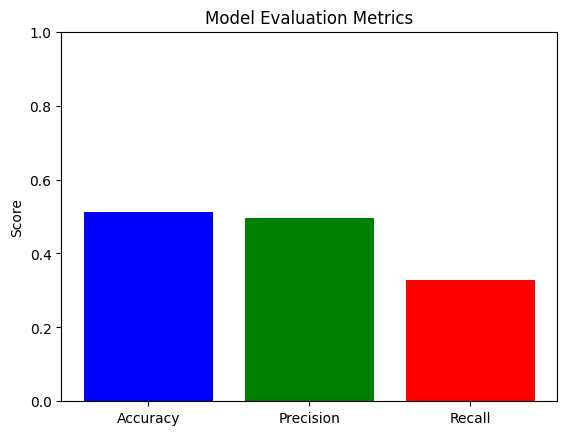

In [22]:
# Visualize the model evaluation metrics

metrics = ['Accuracy', 'Precision', 'Recall']
values = [accuracy, precision, recall]

plt.bar(metrics, values, color=['blue', 'green', 'red'])
plt.ylabel('Score')
plt.title('Model Evaluation Metrics')
plt.ylim(0, 1)  # to set y-axis limits from 0 to 1
plt.show()
